In [1]:
import torch
from torch import nn, optim

from rbm import RBM
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [2]:
EPOCHS = 20
BATCH_SIZE = 128
ETA = 1e-4

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_data = MNIST("data/", train=True, download=True, transform=transform)
test_data = MNIST("data/", train=False, download=True, transform=transform)

In [5]:
train_dloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
model = RBM().cuda()
criterion = nn.BCELoss()

In [7]:
def fake_criterion(v0, v1):
    Fv0 = model.free_energy(v0)
    Fv0 = torch.mean(Fv0)

    Fv1 = model.free_energy(v1)
    Fv1 = torch.mean(Fv1)
    
    return Fv0 - Fv1

In [8]:
def compute_loss(x0, x1):
    return criterion(x1, x0).item()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=ETA)

In [10]:
train_losses = []
test_losses = []

In [11]:
for e in range(EPOCHS):
    train_loss = 0.0
    test_loss = 0.0
    
    model.train()
    
    for x, y in train_dloader:
        n = x.size(0)
        v0 = x.cuda().view(n, -1)
        v0 = v0 / 256
        
        with torch.no_grad():
            v1, p_v1 = model(v0)
            
        loss = fake_criterion(v0, v1)
        train_loss += compute_loss(v0, p_v1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        for x, y in test_dloader:
            n = x.size(0)
            v0 = x.cuda().view(n, -1)
            v0 = v0 / 256
            
            v1, p_v1 = model(v0)
            
            loss = criterion(v0, v1)
            test_loss += compute_loss(v0, p_v1)
            
    train_loss /= len(train_dloader)
    test_loss /= len(test_dloader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Epochs {e+1}/{EPOCHS}")
    print(f"Train fake loss: {train_loss:.8f}")
    print(f"Test fake loss: {test_loss:.8f}")

Epochs 1/20
Train fake loss: 2.92348221
Test fake loss: 2.30106165
Epochs 2/20
Train fake loss: 1.86353517
Test fake loss: 1.49107569
Epochs 3/20
Train fake loss: 1.22018700
Test fake loss: 0.98322981
Epochs 4/20
Train fake loss: 0.80648154
Test fake loss: 0.65105596
Epochs 5/20
Train fake loss: 0.53315495
Test fake loss: 0.43136652
Epochs 6/20
Train fake loss: 0.35313445
Test fake loss: 0.28555778
Epochs 7/20
Train fake loss: 0.23278553
Test fake loss: 0.18941416
Epochs 8/20
Train fake loss: 0.15459509
Test fake loss: 0.12509596
Epochs 9/20
Train fake loss: 0.10300008
Test fake loss: 0.08395006
Epochs 10/20
Train fake loss: 0.06944512
Test fake loss: 0.05655900
Epochs 11/20
Train fake loss: 0.04787075
Test fake loss: 0.03975356
Epochs 12/20
Train fake loss: 0.03378822
Test fake loss: 0.02883577
Epochs 13/20
Train fake loss: 0.02474201
Test fake loss: 0.02182372
Epochs 14/20
Train fake loss: 0.01911300
Test fake loss: 0.01717478
Epochs 15/20
Train fake loss: 0.01547652
Test fake loss: 

In [12]:
import matplotlib.pyplot as plt

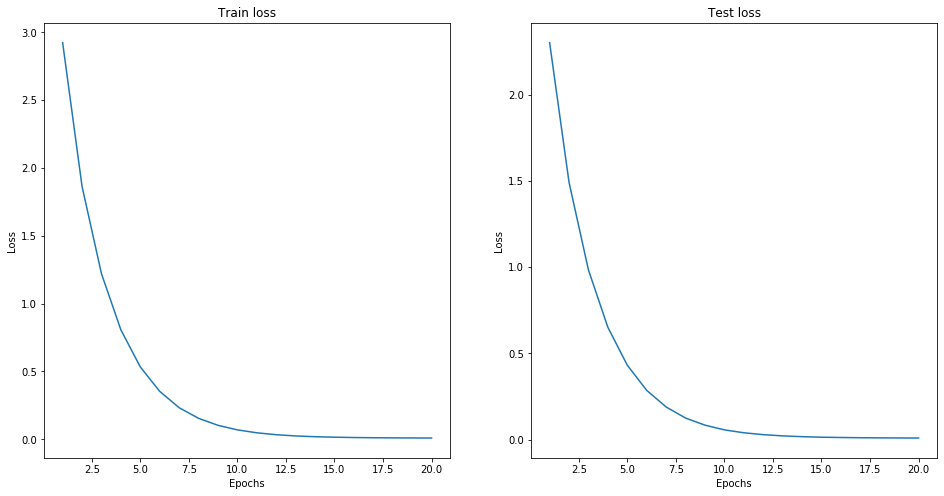

In [15]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses)
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), test_losses)
plt.title("Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()